In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from PIL import Image
import random

print(os.listdir("../input"))

['test-file', 'the-oxfordiiit-pet-dataset']


In [2]:
def cleanAndStore(path):
  image_list = sorted(os.listdir(path + 'images/images'))
  mask_list = sorted(os.listdir(path  + 'annotations/annotations/trimaps/'))

  new_image = []
  new_mask = []

  for imaj in image_list:

    mock = cv2.imread(path + 'images/images/' + imaj, cv2.IMREAD_COLOR)

    try:
      mock = cv2.resize(mock, (128, 128), interpolation=cv2.INTER_AREA)
    except:
      continue
      

    imaj = imaj[0:-3]

    for maske in mask_list:

      maske = maske[0:-3]


      if imaj == maske:
        new_image.append(imaj + 'jpg')
        new_mask.append(maske + 'png')
        mask_list.pop(0)
        break

  return new_image, new_mask
path = '../input/the-oxfordiiit-pet-dataset/'
im, ma = cleanAndStore(path)
print(len(ma))
print(len(im))

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


7384
7384


In [3]:
def collect(images,mask, low, high):

    image_list = []
    mask_list = []

    a = low
    
    for filename in images:
        a += 1
        
        image = cv2.imread(path + 'images/images/' + filename, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (128, 128))
        image = tf.cast(image, tf.float32) / 255.0

        image_list.append(image)
    

        if a == high:
            break

    a = low
    for filename in mask:
        a += 1
        mask = cv2.imread(path + 'annotations/annotations/trimaps/' + filename, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (128, 128))
        mask -= 1
        mask_list.append(mask)

        if a == high:
            break




    return image_list, mask_list


In [4]:
x,y = collect(im,ma,0,6000)
z,t = collect(im,ma,6001,7501)

2022-04-09 10:44:38.747720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 10:44:38.832371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 10:44:38.833135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 10:44:38.835448: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))

    dataset = dataset.batch(batch,drop_remainder=True)

    dataset = dataset.prefetch(10)

    return dataset 

train_dataset = tf_dataset(x,y)

test_dataset = tf_dataset(z,t)



2022-04-09 10:46:21.858297: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.


<function show at 0x7fd791a75c20>


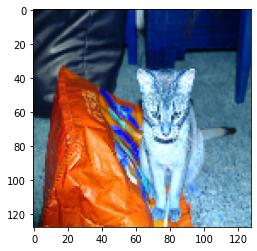

In [6]:
plt.imshow(x[7])
print(plt.show)


<function show at 0x7fd791a75c20>


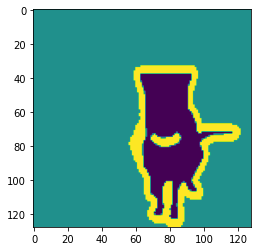

In [7]:
plt.imshow(y[7])
print(plt.show)

In [8]:
BATCH_SIZE = 8
BUFFER_SIZE = 6000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).repeat()


In [9]:
def display(display_list):
  plt.figure(figsize=(15,15))
  title=["Input Image","True Mask","Predicted Mask"]
  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

def double_conv_block(x,n_filters):
  x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
  x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
  
  return x
  

def downsample_block(x,n_filters):
    f=double_conv_block(x,n_filters)
    p=layers.MaxPool2D(2)(f)
    p=layers.Dropout(0.3)(p)
    return f,p


def upsample_block(x,conv_features,n_filters):
  x=layers.Conv2DTranspose(n_filters,3,2,padding="same")(x)
  x=layers.concatenate([x,conv_features])
  x=layers.Dropout(0.3)(x)
  x=double_conv_block(x,n_filters)
  return x






In [10]:
def build_unet_model():
  inputs=layers.Input(shape=(128,128,3))
  # encoder: contracting path - downsample
  f1,p1=downsample_block(inputs,64)
  f2,p2=downsample_block(p1,128)
  f3,p3=downsample_block(p2,256)
  f4,p4=downsample_block(p3,512)

  

  bottleneck=double_conv_block(p4,1024)

  # decoder: expanding path - upsample
  u6=upsample_block(bottleneck,f4,512)
  u7=upsample_block(u6,f3,256)
  u8=upsample_block(u7,f2,128)
  u9=upsample_block(u8,f1,64)

  outputs=layers.Conv2D(3,1,padding="same",activation = "softmax")(u9)

  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
  return unet_model

checkpoint_path = "./sav"
checkpoint_dir = os.path.dirname(checkpoint_path)
#Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=100*BATCH_SIZE)

unet_model = build_unet_model()
# Save the weights using the `checkpoint_path` format
unet_model.save_weights(checkpoint_path.format(epoch=0))
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# unet_model.load_weights(latest)
# unet_model.summary()


unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'] )
                

NUM_EPOCHS = 100
TRAIN_LENGTH = 6000

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5

TEST_LENGTH = 1490

VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

# unet_model.summary()
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              callbacks=[cp_callback],
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_dataset)

2022-04-09 10:46:29.689234: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.


Epoch 1/100


2022-04-09 10:46:31.998897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-09 10:46:33.866061: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


750/750 [==============================] - 70s 80ms/step - loss: 0.7692 - accuracy: 0.6646 - val_loss: 0.6387 - val_accuracy: 0.7426
Epoch 2/100
 50/750 [=>............................] - ETA: 54s - loss: 0.6380 - accuracy: 0.7436
Epoch 00002: saving model to ./sav
750/750 [==============================] - 60s 80ms/step - loss: 0.6035 - accuracy: 0.7594 - val_loss: 0.5493 - val_accuracy: 0.7822
Epoch 3/100
100/750 [===>..........................] - ETA: 50s - loss: 0.5542 - accuracy: 0.7801
Epoch 00003: saving model to ./sav
750/750 [==============================] - 60s 81ms/step - loss: 0.5334 - accuracy: 0.7907 - val_loss: 0.5005 - val_accuracy: 0.8005
Epoch 4/100
150/750 [=====>........................] - ETA: 46s - loss: 0.4805 - accuracy: 0.8144
Epoch 00004: saving model to ./sav
750/750 [==============================] - 60s 81ms/step - loss: 0.4763 - accuracy: 0.8144 - val_loss: 0.4318 - val_accuracy: 0.8306
Epoch 5/100
200/750 [=======>......................] - ETA: 42s - los

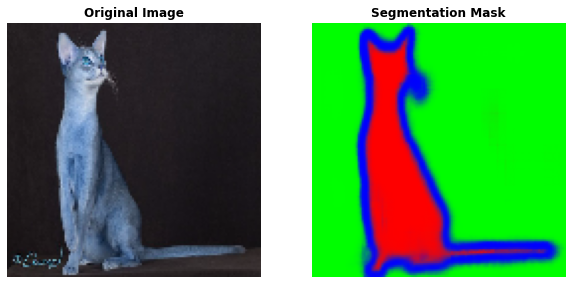

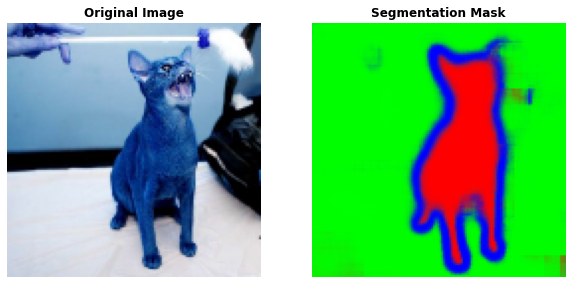

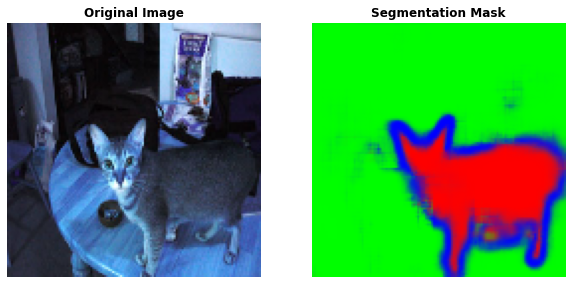

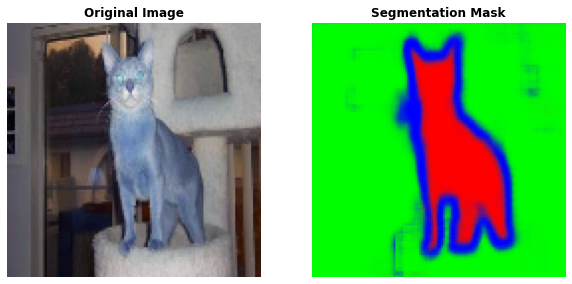

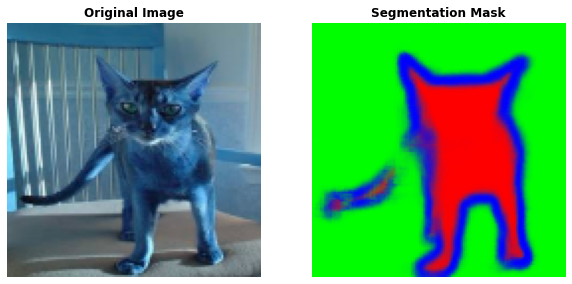

In [11]:
for a in range(100,105):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.axis(False)
    plt.title("Original Image", fontweight="bold")
    
    plt.imshow(x[a])

    plt.subplot(1,2,2)
    plt.axis(False)
    plt.title("Segmentation Mask", fontweight="bold")
    img = np.expand_dims(x[a],axis=0)
    plt.imshow(unet_model.predict(img)[0,:,:,:])

['checkpoint', 'sav.data-00000-of-00001', 'sav.index', '__notebook__.ipynb']
./sav
[0.7692207098007202, 0.6034828424453735, 0.5334279537200928, 0.4762588441371918, 0.4531685709953308, 0.4238382577896118, 0.4057200253009796, 0.3935355246067047, 0.3813549876213074, 0.37035655975341797, 0.36262232065200806, 0.3557817339897156, 0.3423853814601898, 0.3389062285423279, 0.32877418398857117, 0.32550278306007385, 0.3231145739555359, 0.31325241923332214, 0.31324753165245056, 0.3091225326061249, 0.3025016784667969, 0.3024722635746002, 0.2946789264678955, 0.28718802332878113, 0.28777265548706055, 0.2885049283504486, 0.2800111174583435, 0.27835527062416077, 0.2715817987918854, 0.272774338722229, 0.2714521586894989, 0.26424163579940796, 0.2668438255786896, 0.2643468976020813, 0.25752517580986023, 0.2551634609699249, 0.25134095549583435, 0.2524767816066742, 0.24761588871479034, 0.2465554177761078, 0.2483309507369995, 0.23939158022403717, 0.24089635908603668, 0.23874491453170776, 0.23972147703170776, 

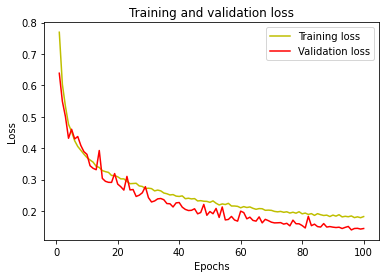

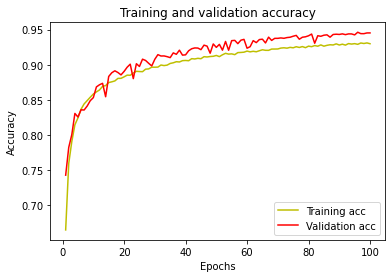

In [12]:
print(os.listdir(checkpoint_dir))
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

loss = model_history .history['loss']
print(loss)
val_loss = model_history .history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_history .history['accuracy']
val_acc = model_history .history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()